### 1) Gathering Input Graphs

In [54]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [55]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-productivity-rate-graphs/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

In [56]:
graphs

[Data(x=[560, 560], edge_index=[2, 440258], edge_attr=[440258, 4], y=[1]),
 Data(x=[603, 603], edge_index=[2, 319768], edge_attr=[319768, 4], y=[1]),
 Data(x=[525, 525], edge_index=[2, 92854], edge_attr=[92854, 4], y=[1]),
 Data(x=[648, 648], edge_index=[2, 477458], edge_attr=[477458, 4], y=[1]),
 Data(x=[484, 484], edge_index=[2, 327346], edge_attr=[327346, 4], y=[1]),
 Data(x=[430, 430], edge_index=[2, 295144], edge_attr=[295144, 4], y=[1]),
 Data(x=[716, 716], edge_index=[2, 348140], edge_attr=[348140, 4], y=[1]),
 Data(x=[706, 706], edge_index=[2, 401906], edge_attr=[401906, 4], y=[1]),
 Data(x=[577, 577], edge_index=[2, 488282], edge_attr=[488282, 4], y=[1]),
 Data(x=[599, 599], edge_index=[2, 582338], edge_attr=[582338, 4], y=[1]),
 Data(x=[451, 451], edge_index=[2, 274074], edge_attr=[274074, 4], y=[1]),
 Data(x=[426, 426], edge_index=[2, 277242], edge_attr=[277242, 4], y=[1]),
 Data(x=[591, 591], edge_index=[2, 571268], edge_attr=[571268, 4], y=[1]),
 Data(x=[199, 199], edge_in

In [57]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [58]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 2) GAT Global Attention Model

In [76]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GlobalAttention

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        # Use GATv2Conv which supports edge_attr via edge_dim parameter
        self.gat1 = GATv2Conv(
            in_channels=in_node_feats,
            out_channels=hidden_dim,
            heads=heads,
            concat=True,
            dropout=0.2,
            edge_dim=in_edge_feats  # Pass edge feature dimension here
        )
        self.gat2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=1,
            concat=True,
            dropout=0.2,
            edge_dim=in_edge_feats
        )

        self.att_pool = GlobalAttention(
            gate_nn=torch.nn.Sequential(torch.nn.Linear(hidden_dim, 1))
        )

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Now pass edge_attr into the conv layers
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)

        x = self.att_pool(x, batch)

        return self.mlp(x).squeeze(1)

In [77]:
import torch.nn as nn
import torch.optim as optim

model = GATGraphRegressor(in_node_feats=max_node_dim, in_edge_feats=max_edge_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [78]:
from sklearn.model_selection import train_test_split
import numpy as np

ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

# Avoid division by zero
if std_y == 0:
    std_y = 1.0

global_mean_y = mean_y
global_std_y = std_y

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

train_data, test_data = train_test_split(graphs_padded, test_size=0.2, random_state=0)


In [79]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_loader = DataLoader(
    train_data,
    batch_size=1,  # smaller batch size to reduce GPU memory use
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):  # max 100 epochs
    torch.cuda.empty_cache()
    model.train()
    train_losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # <-- Fix here
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)  # <-- Fix here too
            loss = criterion(out, batch.y.view(-1))
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_ga.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 0 | Train Loss: 1.1064 | Val Loss: 0.8102
Epoch 1 | Train Loss: 1.0788 | Val Loss: 0.6091
Epoch 2 | Train Loss: 0.6563 | Val Loss: 0.2714
Epoch 3 | Train Loss: 0.3959 | Val Loss: 0.4682
Epoch 4 | Train Loss: 0.2428 | Val Loss: 0.3511
Epoch 5 | Train Loss: 0.1544 | Val Loss: 0.4969
Epoch 6 | Train Loss: 0.1452 | Val Loss: 0.3001
Epoch 7 | Train Loss: 0.0739 | Val Loss: 0.3357
Epoch 8 | Train Loss: 0.0504 | Val Loss: 0.2671
Epoch 9 | Train Loss: 0.0406 | Val Loss: 0.2864
Epoch 10 | Train Loss: 0.0430 | Val Loss: 0.2946
Epoch 11 | Train Loss: 0.0494 | Val Loss: 0.3141
Epoch 12 | Train Loss: 0.0576 | Val Loss: 0.3472
Epoch 13 | Train Loss: 0.0388 | Val Loss: 0.2195
Epoch 14 | Train Loss: 0.0390 | Val Loss: 0.2497
Epoch 15 | Train Loss: 0.0416 | Val Loss: 0.2830
Epoch 16 | Train Loss: 0.0389 | Val Loss: 0.3032
Epoch 17 | Train Loss: 0.0181 | Val Loss: 0.3176
Epoch 18 | Train Loss: 0.0223 | Val Loss: 0.3608
Epoch 19 | Train Loss: 0.0430 | Val Loss: 0.2888
Epoch 20 | Train Loss: 0.0387 

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.load_state_dict(torch.load("best_model_ga.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)  # pass batch as a whole
        all_preds.extend(out.cpu().numpy())
        all_targets.extend(batch.y.view(-1).cpu().numpy())  # flatten targets

# Compute metrics
rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.4685
MAE: 0.3668


### 3) XAI

  0%|          | 0/1 [00:00<?, ?it/s]

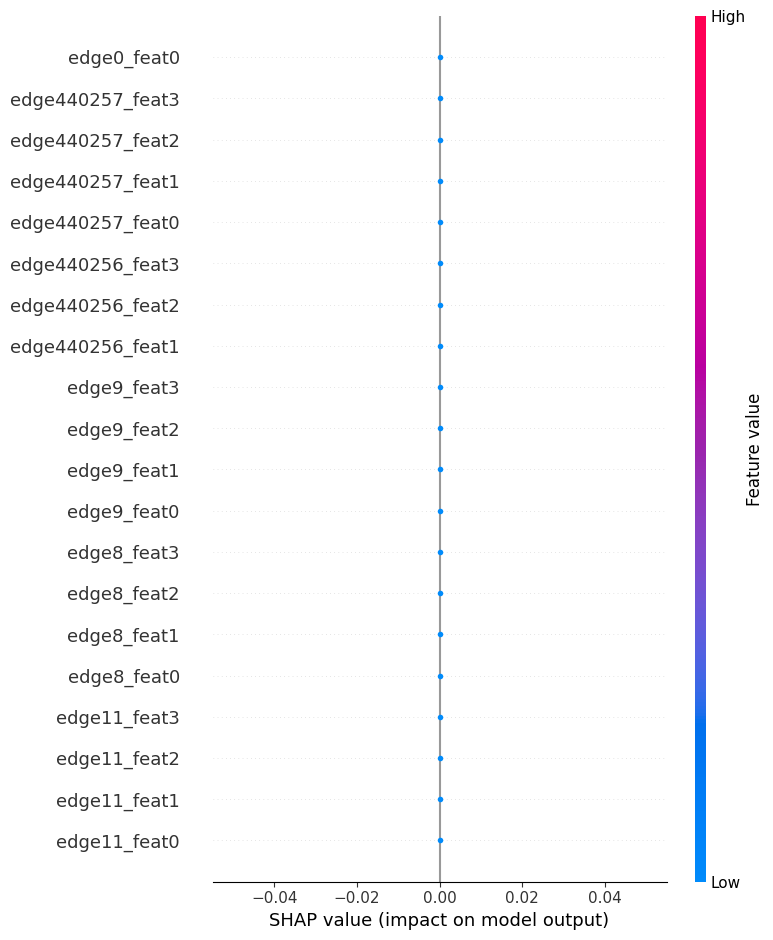

In [83]:
import torch
import shap
from torch_geometric.data import Data, Batch

# === SHAP wrapper for edge features ===
class GATWrapperEdgeFeatures(torch.nn.Module):
    def __init__(self, model, template_graph):
        super().__init__()
        self.model = model
        self.template = template_graph
        self.device = next(model.parameters()).device
        self.n_edges = template_graph.edge_attr.shape[0]
        self.edge_feat_dim = template_graph.edge_attr.shape[1]

    def forward(self, X):
        data_list = []
        for i in range(X.shape[0]):
            edge_attr_i = torch.tensor(X[i], dtype=torch.float32).view(self.n_edges, self.edge_feat_dim)
            g = Data(
                x=self.template.x,  # fixed node features
                edge_index=self.template.edge_index,
                edge_attr=edge_attr_i,
                y=torch.tensor([0.0])
            )
            data_list.append(g)
        batch = Batch.from_data_list(data_list).to(self.device)
        with torch.no_grad():
            out = self.model(batch)
        return out.detach().cpu().numpy()

# === Prepare SHAP inputs ===
template_graph = graphs_padded[0].to(device)
target_num_edges = template_graph.edge_attr.shape[0]
edge_feat_dim = template_graph.edge_attr.shape[1]

# Filter graphs with the same number of edges as the template
uniform_graphs = [g for g in graphs_padded if g.edge_attr.shape[0] == target_num_edges]

# Flatten edge features to 1D per graph for SHAP input
X_test = torch.stack([g.edge_attr.view(-1) for g in uniform_graphs])
X_test_np = X_test.cpu().numpy()

# === Initialize SHAP explainer ===
wrapped_model = GATWrapperEdgeFeatures(model, template_graph)
wrapped_model.eval()

background = X_test_np[:10]  # background dataset for SHAP
explainer = shap.KernelExplainer(wrapped_model, background)

# === Compute SHAP values on a subset ===
shap_values = explainer.shap_values(X_test_np[:3])

# === Plot SHAP summary ===
feature_names = [f"edge{i}_feat{j}" for i in range(target_num_edges) for j in range(edge_feat_dim)]

shap.summary_plot(shap_values, X_test_np[:3], feature_names=feature_names)

The edge features seem to all have a value of 0. There is an issue.

Advice we've gotten about the issue: "The NaNs likely come from your data preprocessing before or during graph creation. Fixing the input data so that edge features have valid numeric values will fix your NaNs, and then SHAP values and feature names will be meaningful."